In [1]:
import pandas as pd
import numpy as np
import shapely

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [4]:
district_coordinates = pd.read_csv('./district_coordinates.csv')   # read in coordinates
del district_coordinates['Unnamed: 0']
district_coordinates = district_coordinates.dropna()
district_coordinates.head()  # 4 coordinate places is an accuracy of 11 meters

,district,lat,lon
0,bernal heights,37.7412,-122.4178
1,castro,37.7609,-122.4350
2,chinatown,37.7941,-122.4078
4,excelsior,37.7244,-122.4272
5,financial district,37.7946,-122.3999


In [6]:
#crime = pd.read_csv('./train.csv')    # read in crime
crime = pd.read_csv('./SFPD_Incidents_-_from_1_January_2003.csv')
crime_sub = crime.sample(100000)   #subset sample
crime_sub.head(1)


,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
958685,51460025,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Thursday,12/29/2005,20:29,MISSION,PSYCHOPATHIC CASE,2000 Block of MISSION ST,-122.41952,37.764229,"(37.764228935718, -122.419520367886)",5146002564020


# Function to map crime location coordinates to districts

![alt text](https://snag.gy/drov4h.jpg)

![alt text](https://snag.gy/iueFGt.jpg)

![alt text](https://snag.gy/JhSIeD.jpg)

![alt text](https://snag.gy/FBvsql.jpg)

![alt text](https://snag.gy/VBGKnm.jpg)

![alt text](https://snag.gy/MaqYbw.jpg)

![alt text](https://snag.gy/sme2St.jpg)

![alt text](https://snag.gy/qd04hF.jpg)

![alt text](https://snag.gy/ul3FW8.jpg)

![alt text](https://snag.gy/R9aHBN.jpg)

![alt text](https://snag.gy/hALYqe.jpg)

In [7]:
# get decimals as a feature X1 X2 from the location coordinates
from decimal import Decimal
def replace_lon(location):
    
    lon = str(location).replace('(','').replace(')','').split(',')
    lon = np.float64(lon[1])
    return lon
    
def replace_lat(location):
    lat = str(location).replace('(','').replace(')','').split(',')
    lat = np.float64(lat[0])
    return lat
    
crime_sub['X1'] = crime_sub.apply(lambda row: replace_lon(row['Location']),axis = 1)
crime_sub['Y1'] = crime_sub.apply(lambda row: replace_lat(row['Location']),axis = 1)

# haversine distances to check which crime occured in what district
%timeit
from haversine import haversine
def check_distance(location):
    #print location
    haversine_list = []
    for d,lat,lon in zip(district_coordinates.district,district_coordinates.lat, district_coordinates.lon):

        haversine_list.append((haversine(location, (lon,lat)),d))
    
    match = sorted(haversine_list)[0][1]
    return match
    
crime_sub['match_district'] = crime_sub.apply(lambda row: check_distance((row['X1'],row['Y1'])), axis = 1 )

In [9]:
# create crime Categories
crime_sub.Category.value_counts()

theft = ['LARCENY/THEFT','VEHICLE THEFT','BURGLARY','ROBBERY','STOLEN PROPERTY','RECOVERED VEHICLE']
drunk = ['DRUG/NARCOTIC','DRUNKENNESS','LIQOUR LAWS','DRIVING UNDER THE INFLUENCE','LIQUOR LAWS']
organized = ['BRIBERY','EXTORTION','PROSTITUTION']
violent = ['ASSAULT','SEX OFFENSES, FORCIBLE','KIDNAPPING']
narcotic = ['DRUG/NARCOTIC']
city = ['VANDALISM','LOITERING']

crime_sub['is_theft'] = crime_sub.Category.apply(lambda x: 1 if x in theft else 0)
crime_sub['is_drunk'] = crime_sub.Category.apply(lambda x: 1 if x in drunk else 0)
crime_sub['is_organized'] = crime_sub.Category.apply(lambda x: 1 if x in organized else 0)
crime_sub['is_violent'] = crime_sub.Category.apply(lambda x: 1 if x in violent else 0)
crime_sub['is_narcotic'] = crime_sub.Category.apply(lambda x: 1 if x in narcotic else 0)
crime_sub['is_city'] = crime_sub.Category.apply(lambda x: 1 if x in city else 0)

## Convert indexes and dates to datetime

In [10]:
from datetime import datetime as dt
print crime_sub.index.dtype
crime_sub['Date'] = pd.to_datetime(crime_sub['Date'])
crime_sub.set_index('Date',inplace= True)
print crime_sub.index.dtype

# create a year function, 2016 is not completely represented
crime_sub['year'] = crime_sub.index.map(lambda val: val.year)
crime_sub.head(1)
crime_sub = crime_sub[crime_sub['year'] < 2016]

int64
datetime64[ns]


In [19]:
posts = pd.read_csv('./craigslist_posts.csv')
posts.head()
posts = posts[posts.bed < 6]

## Transformations

In [20]:
crime_groups = pd.DataFrame(crime_sub.groupby(['year','Category','match_district']).size())

crime_wide = crime_groups.reset_index()
crime_wide.head()

crime_wide.columns = ['year','crime','district','crime_count']
crime_wide.head()

print [x for x in crime_wide.district.values if not type(x) == str]

crime_wide = crime_wide[[True if type(x) == str else False for x in crime_wide.district.values]]

crime_wide.district = crime_wide.district.map(lambda x: x.lower())
crime_wide_ = pd.pivot_table(crime_wide, index=['year','crime'], columns=['district'], fill_value=0)['crime_count'].reset_index()
crime_wide_.head()

crime_trans = crime_wide.T

posts = posts.iloc[:,1:]
posts.head()

crime_trans.columns = np.ravel(crime_trans.ix['crime',:].values)
crime_trans.head()

small_posts = posts

small_posts.shape

small_posts.year.value_counts()

[]


2005    15455
2004     6433
2006     4529
2016     2494
2012     2283
2014     2218
2015     2030
2011     1476
2007      884
2013      772
2003      497
2008      487
2009      195
2010       99
Name: year, dtype: int64

In [21]:


new_dfs = []

for i, row in small_posts.iterrows():
    
    ndf = pd.DataFrame({
            'post':[row.post],
            'year':[row.year],
            'price':[row.price],
            'bed':[row.bed],
            'district1':[row.district1],
            'district2':[row.district2],
            'district3':[row.district3]
        })
    ndf.index = [i]
    
    d1_mask_colmask = (crime_trans.loc['year',:] == row.year) & (crime_trans.loc['district',:] == row.district1)
    d2_mask_colmask = (crime_trans.loc['year',:] == row.year) & (crime_trans.loc['district',:] == row.district2)
    d3_mask_colmask = (crime_trans.loc['year',:] == row.year) & (crime_trans.loc['district',:] == row.district3)
    
    district1_crimes = crime_trans.ix[['crime_count'], d1_mask_colmask]
    district2_crimes = crime_trans.ix[['crime_count'], d2_mask_colmask]
    district3_crimes = crime_trans.ix[['crime_count'], d3_mask_colmask]
    
    district1_crimes.columns = ['D1_'+x for x in district1_crimes.columns]
    district2_crimes.columns = ['D2_'+x for x in district2_crimes.columns]
    district3_crimes.columns = ['D3_'+x for x in district3_crimes.columns]
    
    dist_crimes = pd.concat([district1_crimes, district2_crimes, district3_crimes],
                            axis=1, ignore_index=False)
    
    
    dist_crimes.index = [i]
    
    ndf = pd.concat([ndf, dist_crimes], axis=1, ignore_index=False)
    
    new_dfs.append(ndf)
    
posts_crimes = pd.concat(new_dfs, axis=0, ignore_index=False).fillna(value=0, axis=1)
    
    
    
    

In [56]:
posts_crimes.head()

,D1_ARSON,D1_ASSAULT,D1_BAD CHECKS,D1_BRIBERY,D1_BURGLARY,D1_DISORDERLY CONDUCT,D1_DRIVING UNDER THE INFLUENCE,D1_DRUG/NARCOTIC,D1_DRUNKENNESS,D1_EMBEZZLEMENT,...,bed,district1,district2,district3,post,price,year,district1_code,district2_code,district3_code
0,0,9,0,0,4,1,0,1,0,1,...,1,sunset,parkside,inner sunset,950 1br sunny one bedroom for rent sunset p...,950.0,2003,45,36,14
1,0,7,0,0,5,0,1,1,2,0,...,2,marina,nob hill,nob hill,1500 2br 1 ba cow hollow open house thursday...,1500.0,2003,21,27,27
2,1,37,1,0,10,4,1,34,1,2,...,2,hayes valley,noe valley,visitacion valley,1795 2br spacious completely remodeled 2 bd...,1795.0,2003,11,28,51
3,1,16,0,0,12,2,0,3,1,0,...,0,pacific heights,presidio heights,inner richmond,1180 0br victorian hotel room wprivate bath ...,1180.0,2003,33,40,13
4,1,12,0,0,6,0,0,4,1,0,...,1,inner richmond,outer richmond,inner sunset,1100 1br great landlordgreat tenats inner ri...,1100.0,2003,13,32,14


In [40]:
from sklearn.preprocessing import LabelEncoder

posts_crimes.district1 = posts_crimes.district1.map(lambda x: 'none' if x == 0 else x)
posts_crimes.district2 = posts_crimes.district2.map(lambda x: 'none' if x == 0 else x)
posts_crimes.district3 = posts_crimes.district3.map(lambda x: 'none' if x == 0 else x)

label_encoder = LabelEncoder()

dists = posts_crimes.district1.values.tolist() + posts_crimes.district2.values.tolist() + posts_crimes.district3.values.tolist()
dists = np.unique(dists)
# print dists
# print posts_crimes.district1.unique()
# print posts_crimes.district2.unique()
# print posts_crimes.district3.unique()


label_encoder.fit(dists)

posts_crimes['district1_code'] = label_encoder.transform(posts_crimes.district1.values)
posts_crimes['district2_code'] = label_encoder.transform(posts_crimes.district2.values)
posts_crimes['district3_code'] = label_encoder.transform(posts_crimes.district3.values)

In [41]:

posts_crimes.to_csv('./aggregate_df.csv')

In [35]:
posts_crimes = pd.read_csv('./aggregate_df.csv')
del posts_crimes['Unnamed: 0']

In [36]:
posts_crimes.head()

,D1_ARSON,D1_ASSAULT,D1_BAD CHECKS,D1_BRIBERY,D1_BURGLARY,D1_DISORDERLY CONDUCT,D1_DRIVING UNDER THE INFLUENCE,D1_DRUG/NARCOTIC,D1_DRUNKENNESS,D1_EMBEZZLEMENT,...,bed,district1,district2,district3,post,price,year,district1_code,district2_code,district3_code
0,0,9,0,0,4,1,0,1,0,1,...,1,sunset,parkside,inner sunset,950 1br sunny one bedroom for rent sunset p...,950.0,2003,45,36,14
1,0,7,0,0,5,0,1,1,2,0,...,2,marina,nob hill,nob hill,1500 2br 1 ba cow hollow open house thursday...,1500.0,2003,21,27,27
2,1,37,1,0,10,4,1,34,1,2,...,2,hayes valley,noe valley,visitacion valley,1795 2br spacious completely remodeled 2 bd...,1795.0,2003,11,28,51
3,1,16,0,0,12,2,0,3,1,0,...,0,pacific heights,presidio heights,inner richmond,1180 0br victorian hotel room wprivate bath ...,1180.0,2003,33,40,13
4,1,12,0,0,6,0,0,4,1,0,...,1,inner richmond,outer richmond,inner sunset,1100 1br great landlordgreat tenats inner ri...,1100.0,2003,13,32,14


In [37]:
posts_crimes = posts_crimes[posts_crimes.price < 50000]

In [43]:
target = posts_crimes.price
tmp = posts_crimes[[col for col in posts_crimes if posts_crimes[col].dtype != object or col == 'district1']]

print posts_crimes.post.dtype

object


In [44]:
tmp.head()

,D1_ARSON,D1_ASSAULT,D1_BAD CHECKS,D1_BRIBERY,D1_BURGLARY,D1_DISORDERLY CONDUCT,D1_DRIVING UNDER THE INFLUENCE,D1_DRUG/NARCOTIC,D1_DRUNKENNESS,D1_EMBEZZLEMENT,...,D3_VEHICLE THEFT,D3_WARRANTS,D3_WEAPON LAWS,bed,district1,price,year,district1_code,district2_code,district3_code
0,0,9,0,0,4,1,0,1,0,1,...,17,0,1,1,sunset,950.0,2003,45,36,14
1,0,7,0,0,5,0,1,1,2,0,...,0,0,0,2,marina,1500.0,2003,21,27,27
2,1,37,1,0,10,4,1,34,1,2,...,57,22,6,2,hayes valley,1795.0,2003,11,28,51
3,1,16,0,0,12,2,0,3,1,0,...,24,7,0,0,pacific heights,1180.0,2003,33,40,13
4,1,12,0,0,6,0,0,4,1,0,...,17,0,1,1,inner richmond,1100.0,2003,13,32,14


In [104]:
bigml = [c for c in tmp if 'D1' in c ]+['bed','year','district1_code','district1','price']
bigml = tmp[bigml]
bigml.to_csv('bigml.csv')

In [105]:
pd.read_csv('./bigml.csv')

,Unnamed: 0,D1_ARSON,D1_ASSAULT,D1_BAD CHECKS,D1_BRIBERY,D1_BURGLARY,D1_DISORDERLY CONDUCT,D1_DRIVING UNDER THE INFLUENCE,D1_DRUG/NARCOTIC,D1_DRUNKENNESS,...,D1_TRESPASS,D1_VANDALISM,D1_VEHICLE THEFT,D1_WARRANTS,D1_WEAPON LAWS,bed,year,district1_code,district1,price
0,0,0,9,0,0,4,1,0,1,0,...,0,13,7,1,1,1,2003,45,sunset,950.0
1,1,0,7,0,0,5,0,1,1,2,...,0,7,13,1,1,2,2003,21,marina,1500.0
2,2,1,37,1,0,10,4,1,34,1,...,8,21,37,30,3,2,2003,11,hayes valley,1795.0
3,3,1,16,0,0,12,2,0,3,1,...,2,7,18,0,0,0,2003,33,pacific heights,1180.0
4,4,1,12,0,0,6,0,0,4,1,...,3,5,24,7,0,1,2003,13,inner richmond,1100.0
5,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,2003,0,0,1851.0
6,6,1,20,0,0,14,2,1,7,1,...,3,10,31,6,0,2,2003,41,russian hill,2100.0
7,7,0,9,0,0,4,1,0,1,0,...,0,13,7,1,1,2,2003,45,sunset,1550.0
8,8,1,37,1,0,10,4,1,34,1,...,8,21,37,30,3,3,2003,11,hayes valley,2495.0
9,9,1,53,0,0,10,7,2,81,5,...,0,19,54,47,2,3,2003,26,mission district,1995.0


In [99]:
D1 = [c for c in tmp if 'D1' in c ]+['bed','year','district1_code']
tmp[D1].head()

,D1_ARSON,D1_ASSAULT,D1_BAD CHECKS,D1_BRIBERY,D1_BURGLARY,D1_DISORDERLY CONDUCT,D1_DRIVING UNDER THE INFLUENCE,D1_DRUG/NARCOTIC,D1_DRUNKENNESS,D1_EMBEZZLEMENT,...,D1_SUICIDE,D1_SUSPICIOUS OCC,D1_TRESPASS,D1_VANDALISM,D1_VEHICLE THEFT,D1_WARRANTS,D1_WEAPON LAWS,bed,year,district1_code
0,0,9,0,0,4,1,0,1,0,1,...,0,4,0,13,7,1,1,1,2003,45
1,0,7,0,0,5,0,1,1,2,0,...,0,1,0,7,13,1,1,2,2003,21
2,1,37,1,0,10,4,1,34,1,2,...,0,9,8,21,37,30,3,2,2003,11
3,1,16,0,0,12,2,0,3,1,0,...,0,4,2,7,18,0,0,0,2003,33
4,1,12,0,0,6,0,0,4,1,0,...,1,9,3,5,24,7,0,1,2003,13


In [59]:
district_codes_df = tmp[D1]['district1_code']

In [60]:
district_codes_df.head()

0    45
1    21
2    11
3    33
4    13
Name: district1_code, dtype: int64

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

X = tmp[D1]
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

lm = LinearRegression()

model = lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)
print model.score(X_test, y_test)   # coefficient of r2
print model.score(X_test,y_pred)


0.444580773788
1.0


In [62]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(tmp[D1], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


param_grid = {'max_depth': np.arange(3, 10),'min_samples_split':[2,5,10]}

tree = GridSearchCV(DecisionTreeRegressor(criterion='mse'), param_grid, cv = 10,n_jobs = -1)

tree.fit(X_train, y_train)

tree_preds = tree.predict(X_test)
print X_test.shape,y_test.shape


tree_performance = tree.score(X_test, y_test)

print tree_preds
print tree_performance
print tree.best_params_
print tree.grid_scores_
print tree.best_estimator_
print tree.best_score_


(13143, 41) (13143,)
[ 1681.25806452  2183.47222222  1807.62538226 ...,  1156.06732348
  1939.92307692  2110.93356643]
0.563376821964
{'min_samples_split': 5, 'max_depth': 9}
[mean: 0.39712, std: 0.02697, params: {'min_samples_split': 2, 'max_depth': 3}, mean: 0.39712, std: 0.02697, params: {'min_samples_split': 5, 'max_depth': 3}, mean: 0.39712, std: 0.02697, params: {'min_samples_split': 10, 'max_depth': 3}, mean: 0.43027, std: 0.02602, params: {'min_samples_split': 2, 'max_depth': 4}, mean: 0.43027, std: 0.02602, params: {'min_samples_split': 5, 'max_depth': 4}, mean: 0.43027, std: 0.02602, params: {'min_samples_split': 10, 'max_depth': 4}, mean: 0.47112, std: 0.03201, params: {'min_samples_split': 2, 'max_depth': 5}, mean: 0.47112, std: 0.03201, params: {'min_samples_split': 5, 'max_depth': 5}, mean: 0.47112, std: 0.03201, params: {'min_samples_split': 10, 'max_depth': 5}, mean: 0.50823, std: 0.03164, params: {'min_samples_split': 2, 'max_depth': 6}, mean: 0.51052, std: 0.02758, pa

(13143, 41) (13143,)
[ 3299.5         1785.75515464  2743.07246377 ...,  2288.01415094
  1658.09961686  1306.79558011]
performance r2: 0.555875557674
[  6.99551248e-06   1.53788294e-02   5.08776291e-05   9.89117647e-05
   5.93489396e-03   1.80362827e-04   7.00348682e-05   2.43978932e-02
   2.84053582e-03   1.83106250e-04   0.00000000e+00   5.37130273e-05
   3.15396504e-04   2.60317068e-03   0.00000000e+00   2.38553162e-03
   7.84984771e-02   2.75436095e-04   1.06117791e-04   2.90618181e-02
   6.70945882e-03   1.31230146e-02   0.00000000e+00   0.00000000e+00
   1.55719423e-02   7.36821951e-04   1.66230681e-03   2.20978716e-03
   3.54056343e-03   0.00000000e+00   2.85279446e-04   2.46878064e-04
   7.95144890e-03   8.30773938e-05   2.03680577e-03   8.94199374e-03
   5.07353333e-03   3.63383123e-03   4.03657934e-01   2.91138640e-01
   7.09545816e-02]


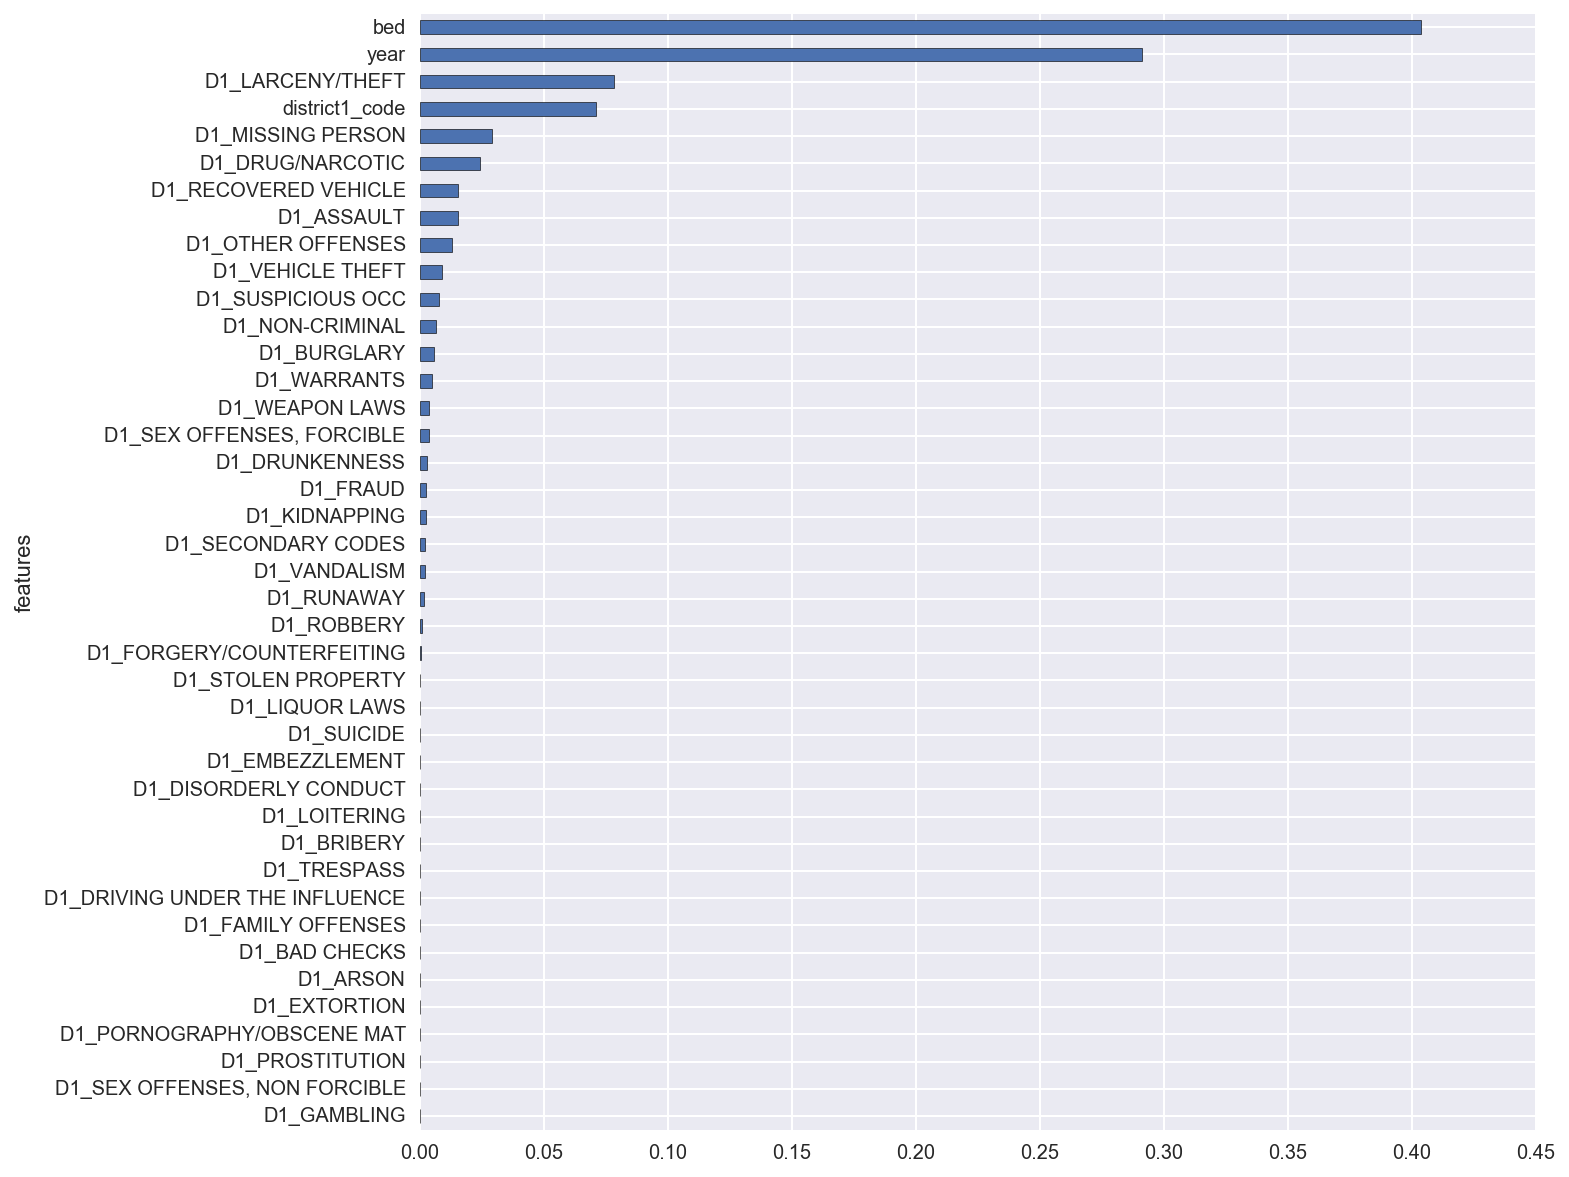

In [63]:
# best fit tree regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(tmp[D1], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

tree = DecisionTreeRegressor(criterion='mse', max_depth = 9, min_samples_split = 5)

tree.fit(X_train, y_train)

tree_preds = tree.predict(X_test)
print X_test.shape,y_test.shape


tree_performance = tree.score(X_test, y_test)

print tree_preds
print 'performance r2:',tree_performance
print tree.feature_importances_

features_df = pd.DataFrame([col for col in tmp[D1]],[i for i in tree.feature_importances_]).reset_index()

sns.set(rc={"figure.figsize": (10,10)})

features_df.rename(columns = {'index':'score',0:'features'},inplace = True)

features_df.set_index('features').score.sort_values().plot(kind = 'barh')

# 'year','bed','weapon laws',

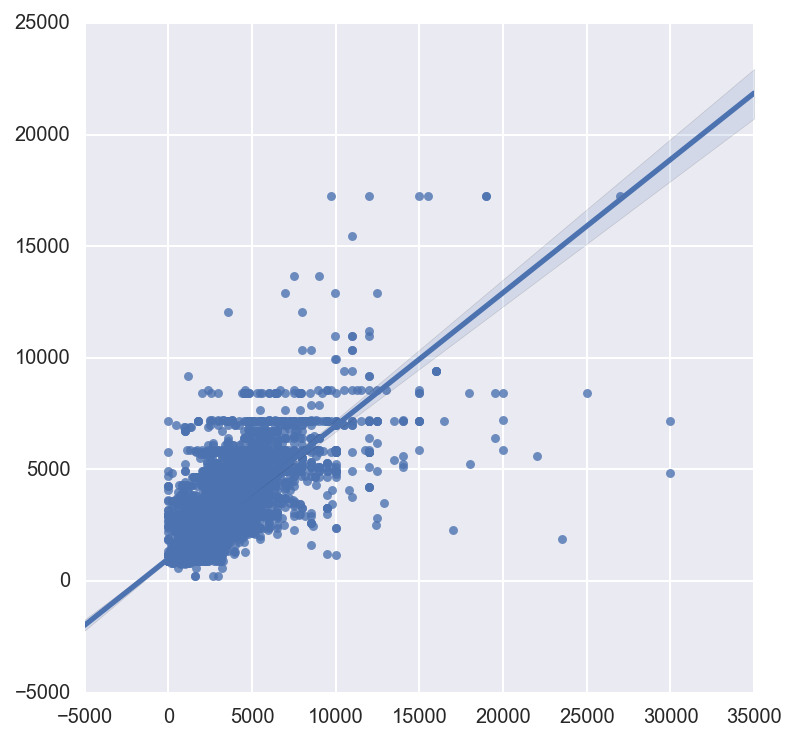

In [20]:
sns.set(rc={"figure.figsize": (6, 6)})
sns.regplot(y_test,tree_preds)

In [21]:
selected_features = [i for i in features_df[features_df.score > .01].features]

# best fit tree regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(tmp[D1][selected_features], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

tree = DecisionTreeRegressor(criterion='mse', max_depth = 9, min_samples_split = 5)

tree.fit(X_train, y_train)

tree_preds = tree.predict(X_test)
print X_test.shape,y_test.shape

print target[0:3]
tree_performance = tree.score(X_test, y_test)

print tree_preds
print 'performance r2:',tree_performance
print tree.feature_importances_

#eatures_df = pd.DataFrame([col for col in tmp[D1]],[i for i in tree.feature_importances_]).reset_index()

(13143, 8) (13143,)
0     950.0
1    1500.0
2    1795.0
Name: price, dtype: float64
[  954.07792208  2131.07368421  2024.74285714 ...,  4201.359375
  1129.15584416  1702.90560472]
performance r2: 0.580923662729
[ 0.03200039  0.0382787   0.08050389  0.03228796  0.00562599  0.40715671
  0.31512189  0.08902447]


## Random Forest

In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

forest = RandomForestRegressor(random_state=0, n_estimators=1000, min_samples_split = 5)



X_train, X_test, y_train, y_test = train_test_split(tmp[D1], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

forest.fit(X_train, y_train)

forest_preds = forest.predict(X_test)

# forest_preds = cross_val_score(estimator = forest, X_test, y= y_test, scoring=None, cv=5, n_jobs=-1, verbose=0, fit_params=None)

forest_performance = forest.score(X_test, y_test)

print forest_preds
print 'forest r2:',forest_performance
print forest
print forest.get_params

[ 1483.20256673  2584.53691262  2262.79302801 ...,  3641.79299371
  1880.98239246  1679.28056462]
forest r2: 0.610046073087
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
<bound method RandomForestRegressor.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)>


performance 0.600623386964


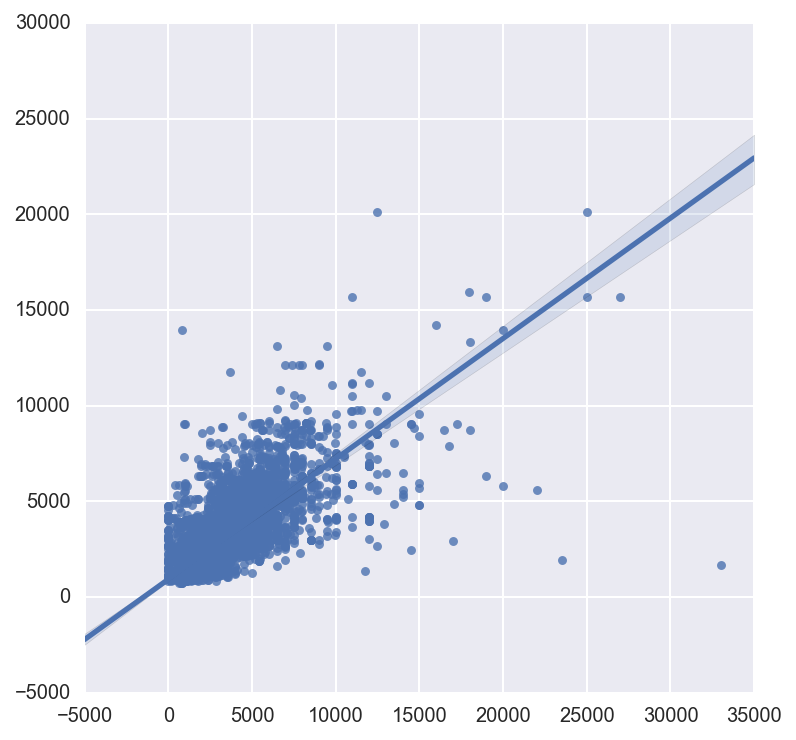

In [23]:
print 'performance', forest_performance
sns.set(rc={"figure.figsize": (6, 6)})
sns.regplot(y_test,forest_preds)

In [65]:
# random forest selected features

# random forest selected features
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

forest = RandomForestRegressor(random_state=0, n_estimators=1000, min_samples_split = 5)



X_train, X_test, y_train, y_test = train_test_split(tmp[D1][selected_features], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

forest.fit(X_train, y_train)

forest_preds = forest.predict(X_test)

# forest_preds = cross_val_score(estimator = forest, X_test, y= y_test, scoring=None, cv=5, n_jobs=-1, verbose=0, fit_params=None)

forest_performance = forest.score(X_test, y_test)

print forest_preds
print 'forest r2:',forest_performance
print forest
print forest.get_params

[ 1881.70876707  1815.69300801  1523.6198641  ...,  2151.34964454
  1326.84133763  4184.36203654]
forest r2: 0.591837068543
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
<bound method RandomForestRegressor.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)>


In [141]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
features = {}

tmp = posts_crimes[[col for col in posts_crimes if posts_crimes[col].dtype != object or col == 'district1']]
D1 = [c for c in tmp if 'D1' in c ]+['bed','year','district1','price']
group_forest_df = tmp[D1]

for district, group_df in tmp[D1].groupby("district1"):
    try: 
        print district
        target = group_df.price
        predictors = group_df[[col for col in group_df if col not in ['price','district1']]]


        X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.33)


        y_train = np.ravel(y_train)
        y_test = np.ravel(y_test)

        model = RandomForestRegressor()

        forest = model.fit(X_train, y_train)

        features[district] = forest.feature_importances_
        
    except:
        continue

0
bernal heights
castro
chinatown
downtown
excelsior
financial district
glen park
golden gate park
haight ashbury
hayes valley
ingleside
inner richmond
inner sunset
lakeshore
lincoln park
lone mountain
lower haight
marina
merced
mission bay
mission district
nob hill
noe valley
north beach
oceanview
outer mission
outer richmond
pacific heights
panhandle
parkside
portola
potrero hill
presidio
presidio heights
russian hill
seacliff
south beach
south of market
sunset
tenderloin
treasure island
twin peaks
upper market
usf
visitacion valley
west of twin peaks
western addition


In [145]:
features_df = pd.DataFrame(features).T

In [160]:
features_df.columns = [i for i in predictors.columns]
features_df = features_df.T

In [171]:
features_df.head()

,0,bernal heights,castro,chinatown,downtown,excelsior,financial district,glen park,golden gate park,haight ashbury,...,south beach,south of market,sunset,tenderloin,treasure island,twin peaks,upper market,usf,visitacion valley,western addition
D1_ARSON,0.0,0.000198,0.003845,0.0,0.0,0.0,0.000730,0.000000,0.000000,0.000020,...,0.000188,0.099395,0.000217,0.000000,0.000000,0.000000,0.0,0.001045,0.001447,0.000000
D1_ASSAULT,0.0,0.002357,0.000000,0.0,0.0,0.0,0.014672,0.003353,0.087801,0.005978,...,0.000967,0.000000,0.011803,0.000000,0.000088,0.003647,0.0,0.000902,0.006254,0.003734
D1_BAD CHECKS,0.0,0.000126,0.000000,0.0,0.0,0.0,0.000187,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000077,0.000000,0.000000,0.000762,0.0,0.000000,0.001058,0.000000
D1_BRIBERY,0.0,0.000747,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000147,0.000000,0.000105,0.000000,0.000000,0.000000,0.0,0.000085,0.015089,0.000020
D1_BURGLARY,0.0,0.002597,0.000000,0.0,0.0,0.0,0.012776,0.000174,0.000028,0.006023,...,0.002340,0.000000,0.001597,0.000451,0.000000,0.010209,0.0,0.012352,0.003792,0.132021


mission district
south of market
marina
russian hill
north beach
tenderloin


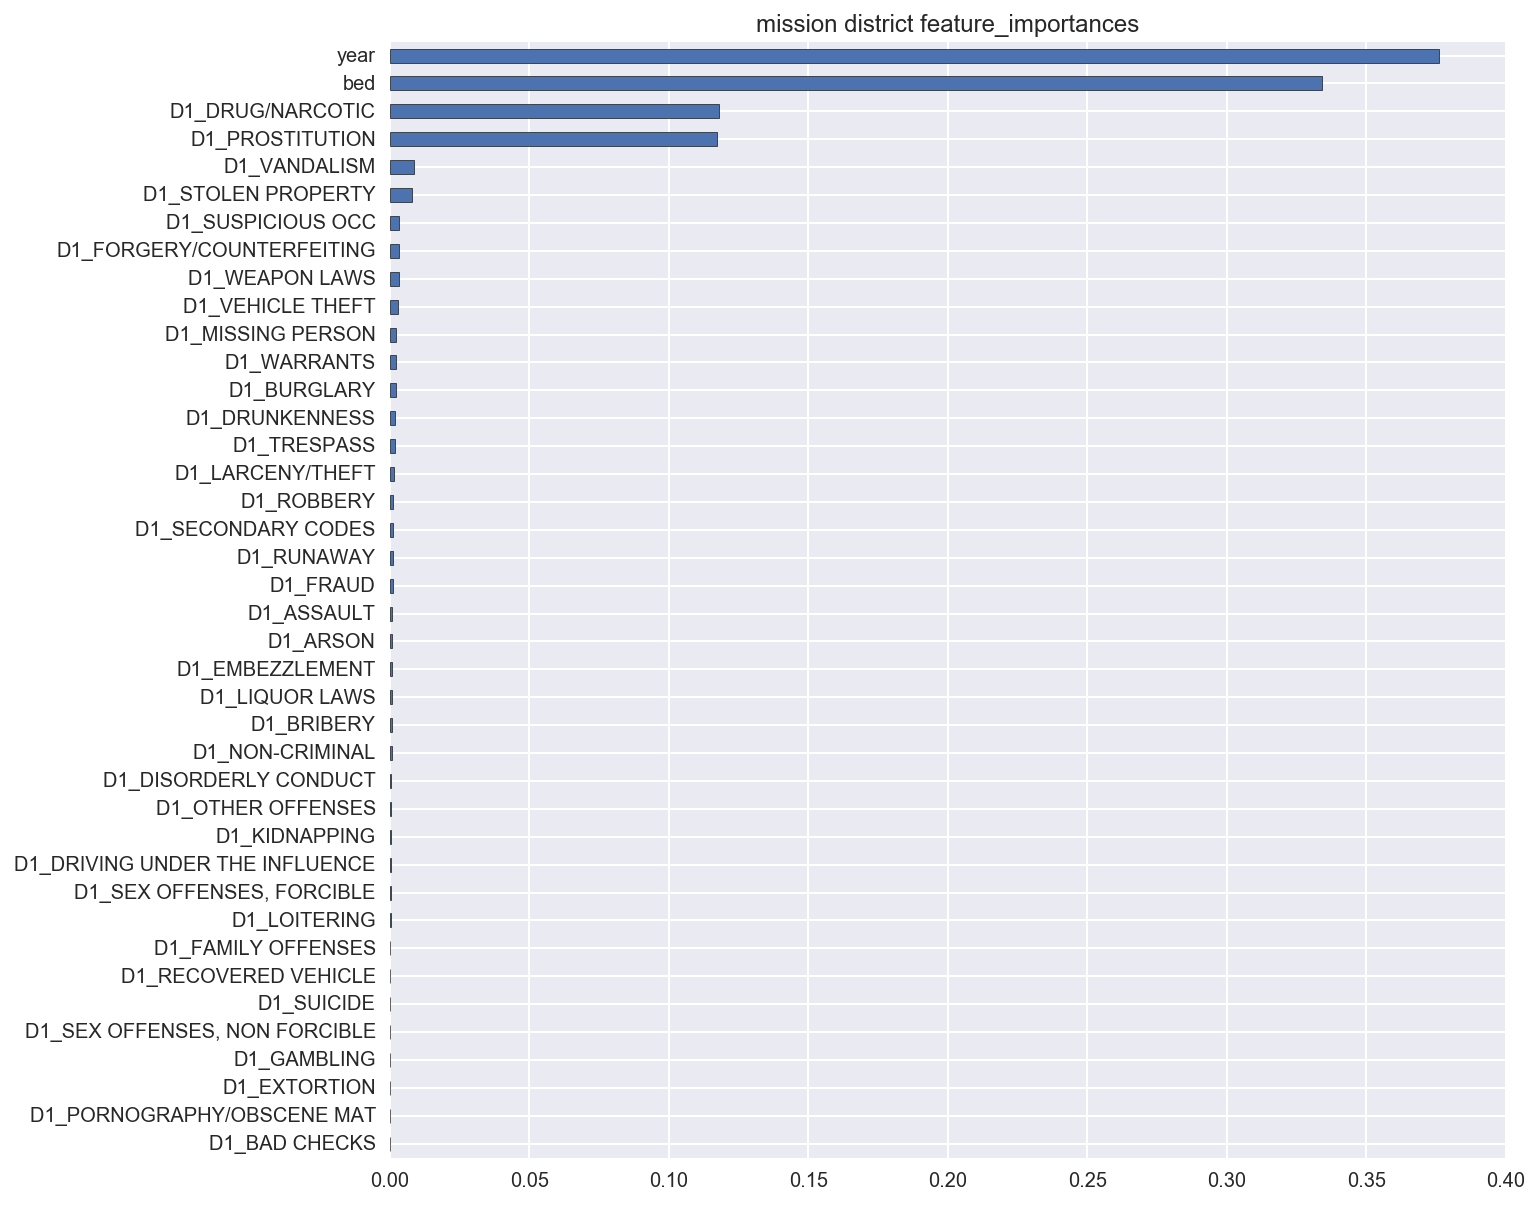

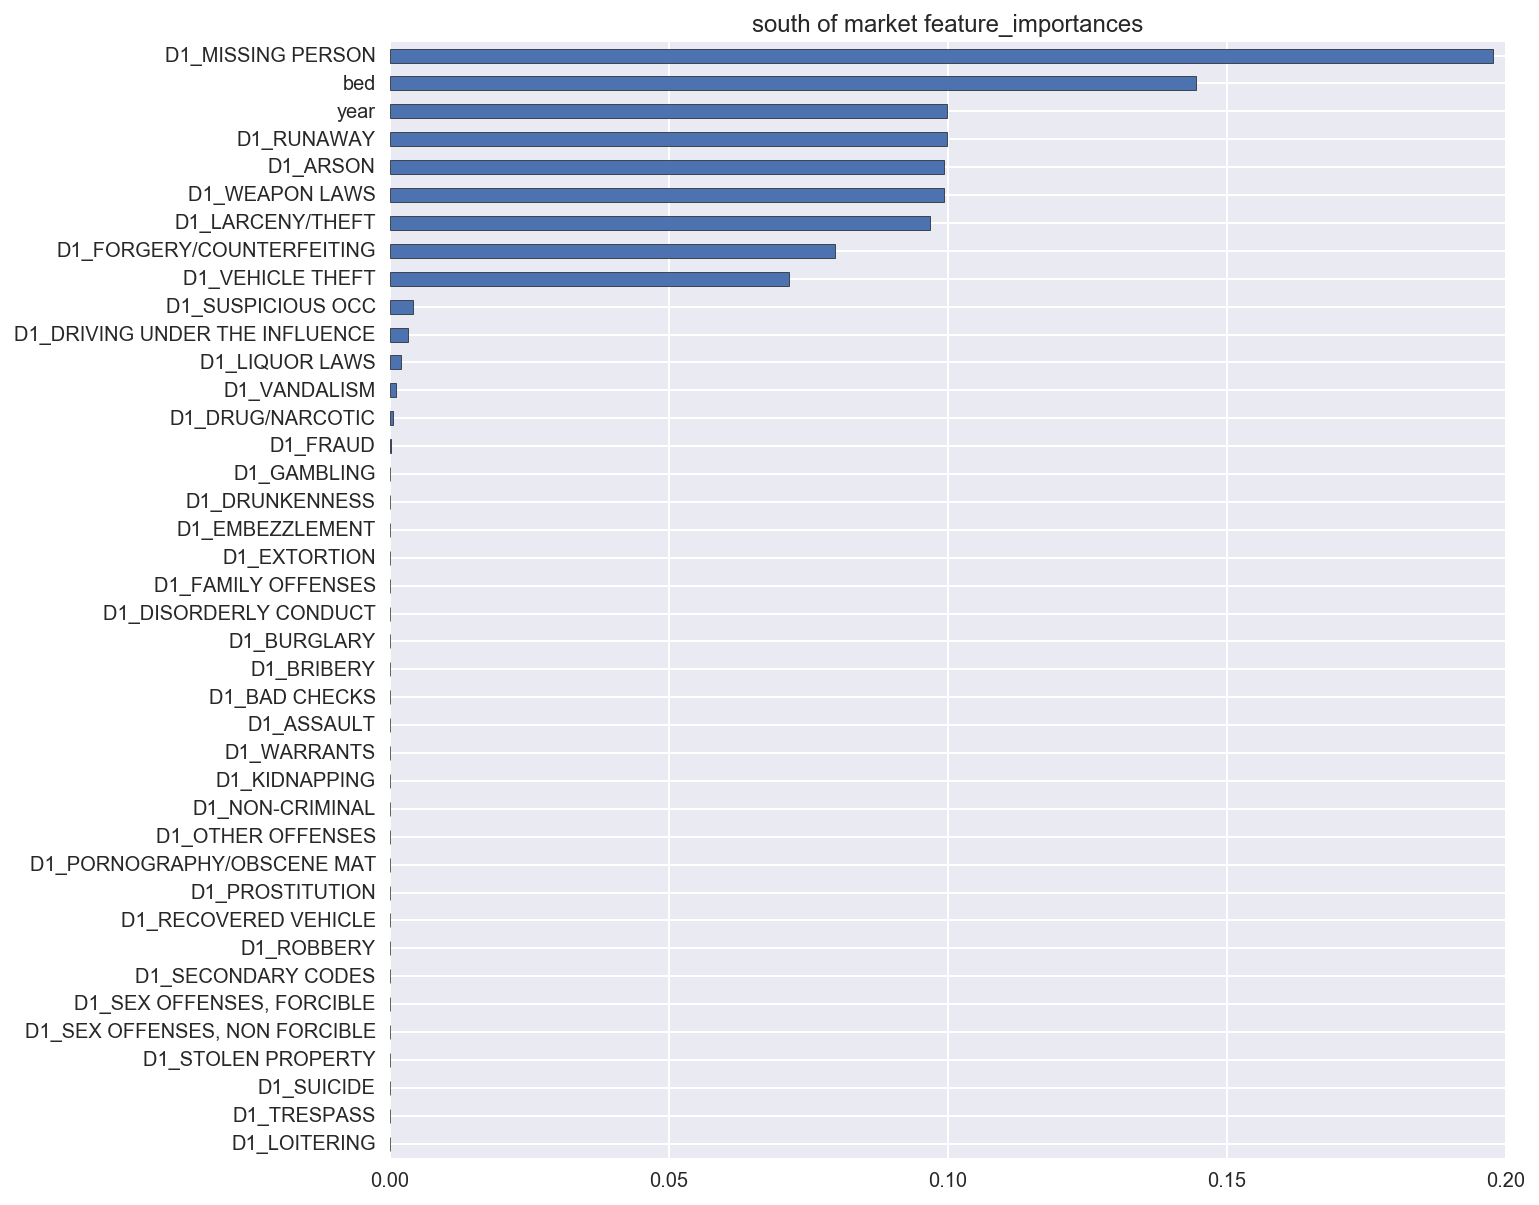

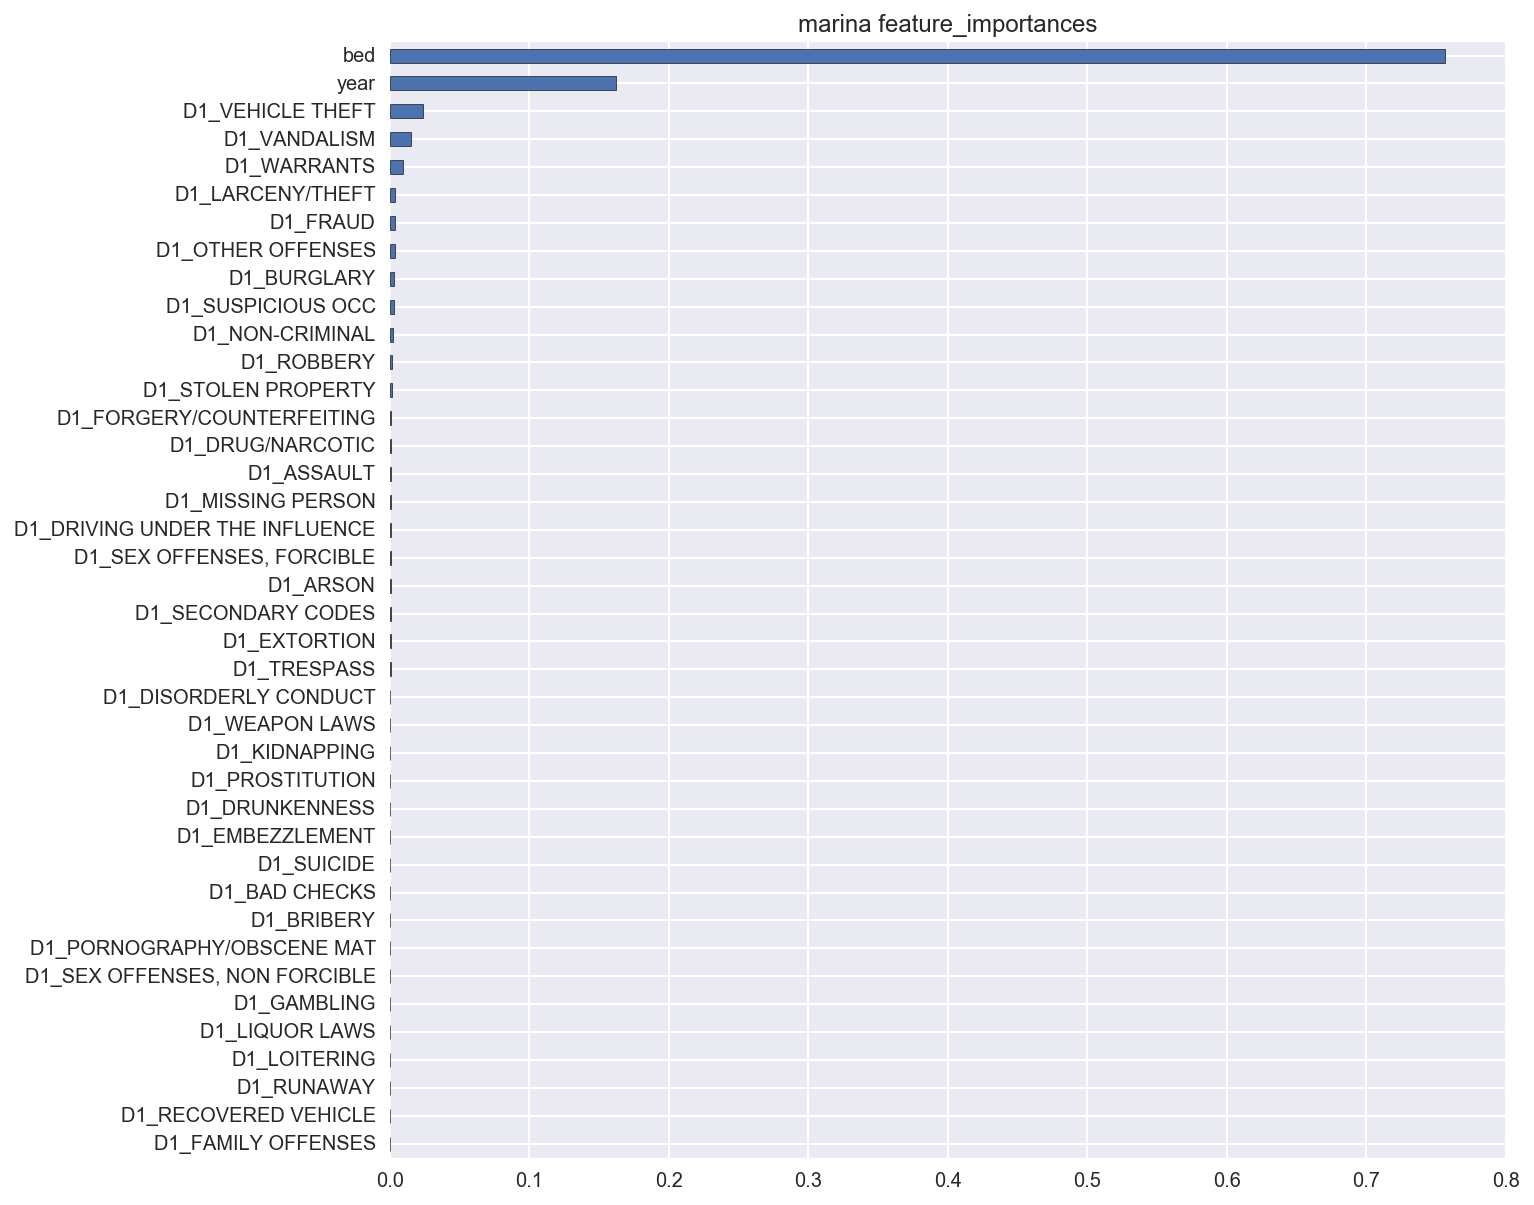

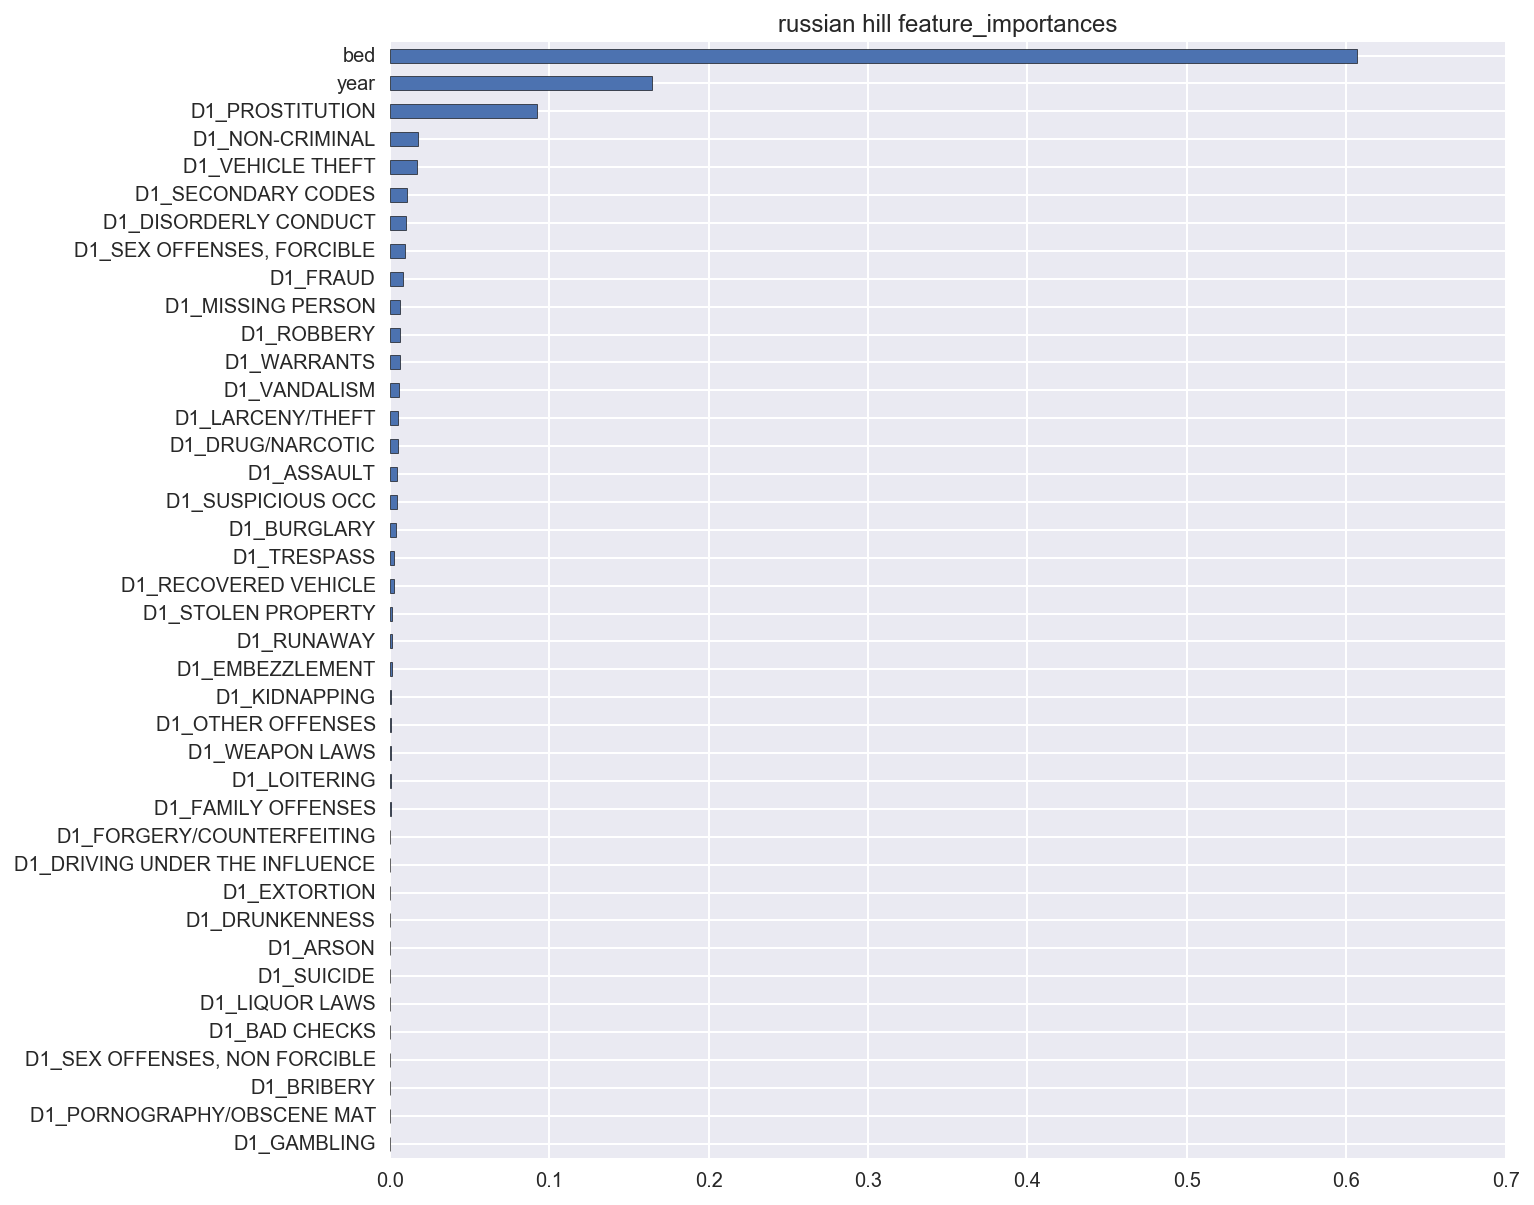

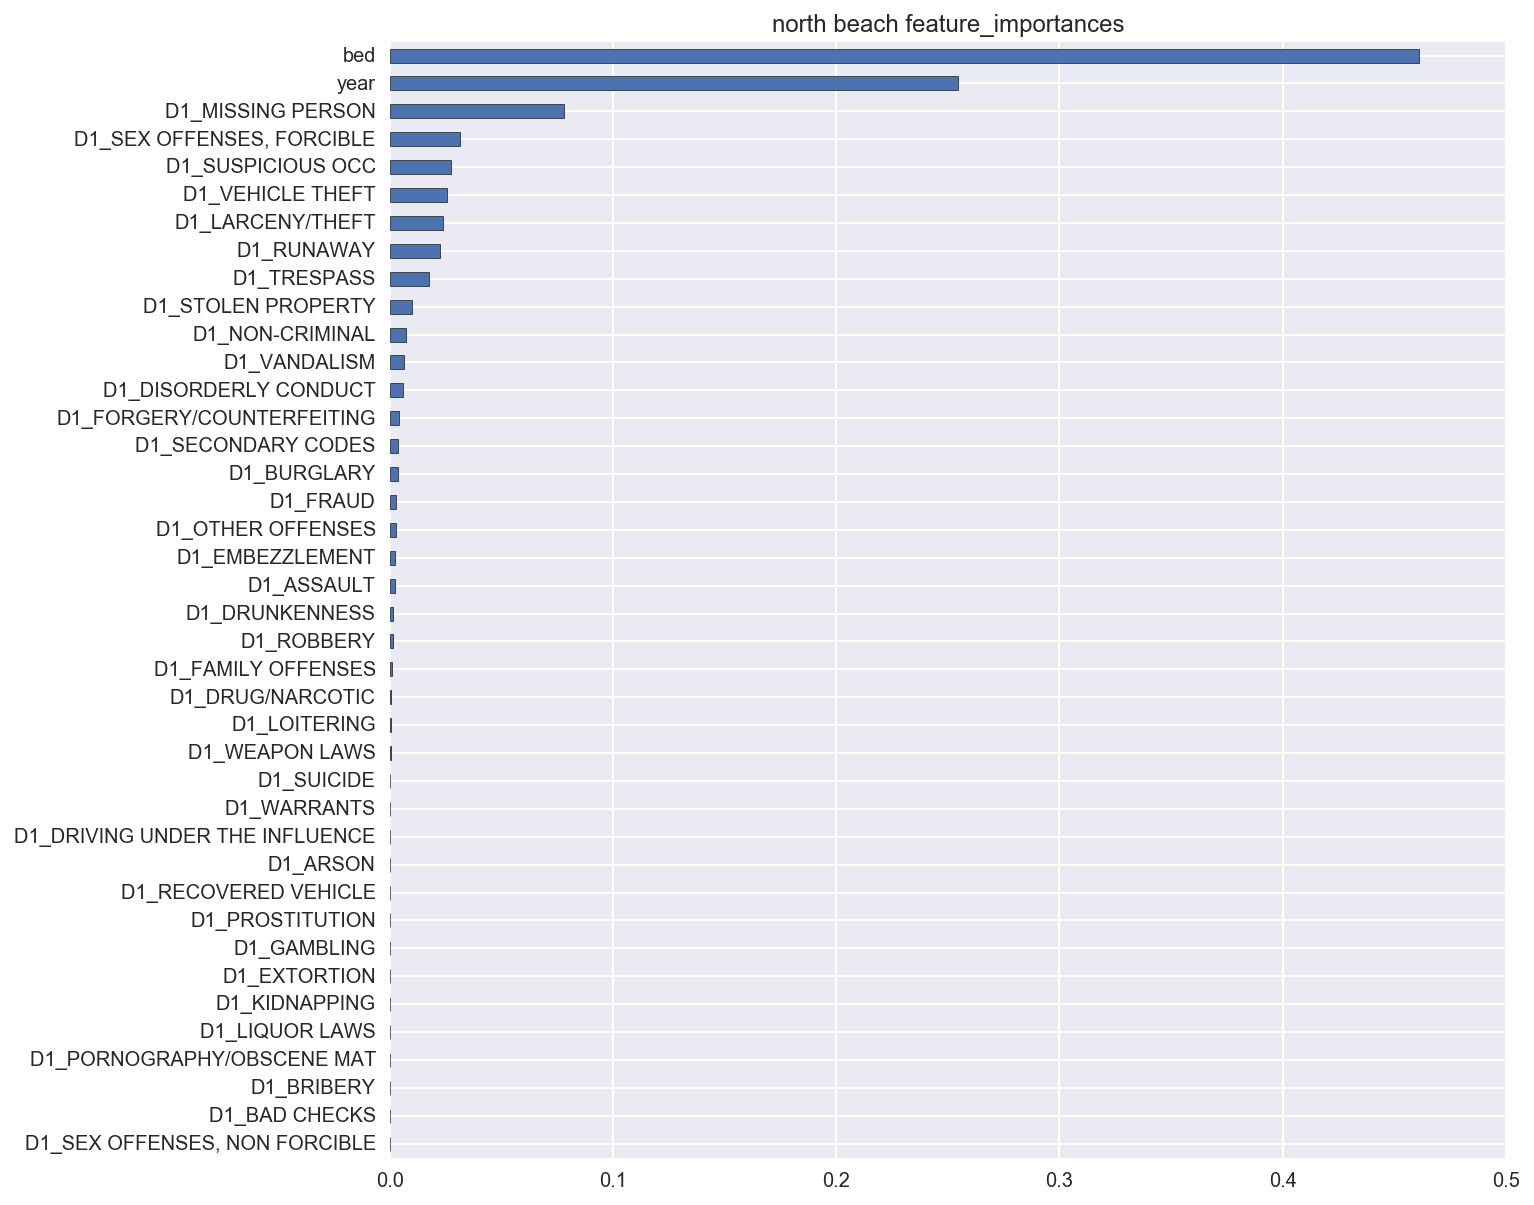

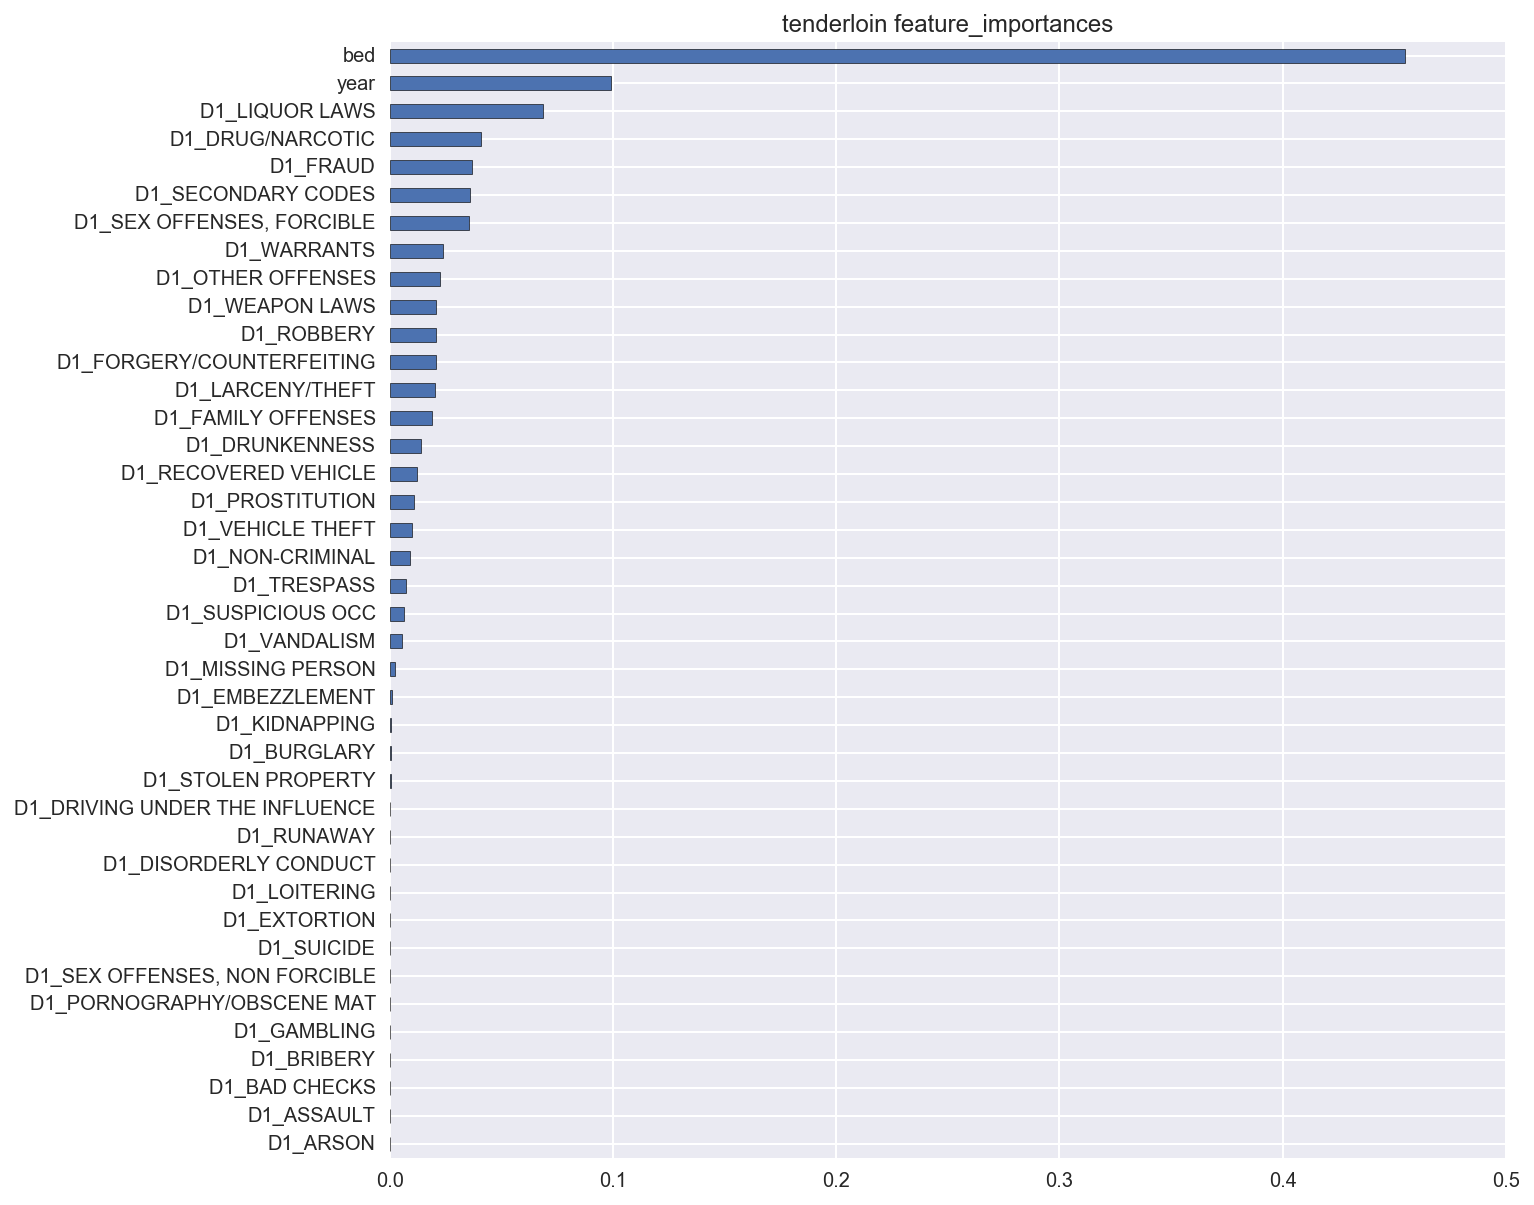

In [185]:
for index,i in enumerate(['mission district','south of market','marina','russian hill','north beach','tenderloin']):
    plt.figure(index)
    features_df_sub = features_df[i].sort_values()
    features_df_sub.plot(kind = 'barh',title = i +' feature_importances')
    print i

In [ ]:
#